In [470]:
import os
import pandas as pd
import scipy as sp
import numpy as np
import random
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import yfinance as yf
from arch import arch_model
from scipy import random
from scipy.stats import shapiro
from scipy.stats import probplot
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch.univariate import RiskMetrics2006, ZeroMean
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
import arch
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m")
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
plt.style.use('bmh') 
plt.rcParams['figure.figsize'] = [16,9]
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
%matplotlib inline

# Download e análise dos dados

Baixados 1630 linhas de dados.


Close                                            
             FLRY3.SA   GNDI3.SA   HYPE3.SA   RADL3.SA  SULA11.SA
Date                                                             
2021-07-26  24.129999  80.169998  36.250000  26.129999  31.709999
2021-07-27  23.910000  80.080002  35.400002  26.070000  30.950001
2021-07-28  24.330000  81.699997  36.200001  26.370001  31.110001
2021-07-29  24.059999  81.900002  36.480000  26.000000  30.790001
2021-07-30  23.360001  80.000000  35.650002  25.240000  30.090000

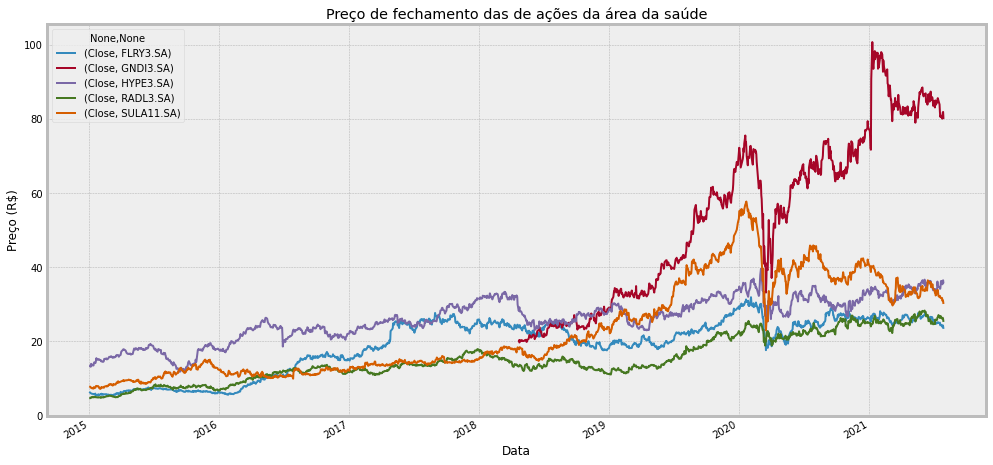

In [471]:
df_yahoo = yf.download(['HYPE3.SA','SULA11.SA','FLRY3.SA', 'GNDI3.SA','RADL3.SA'],
                      start = '2015-01-01',
                      auto_adjust=True,
                      progress = False)

# Mantemos apenas o preço ajustado de fechamento
df = df_yahoo.loc[:, ['Close']]

print(f'Baixados {df.shape[0]} linhas de dados.')


df.plot(figsize=(15, 8),
        title='Preço de fechamento das de ações da área da saúde',
        ylabel = 'Preço (R$)',
        xlabel = 'Data', legend = True
       )
df.tail()

In [617]:
returns_df = df['Close'].pct_change().dropna()
returns_df.head()

,FLRY3.SA,GNDI3.SA,HYPE3.SA,RADL3.SA,SULA11.SA
Date,,,,,
2018-04-24,-0.009363,0.018272,0.008827,0.008889,-0.013857
2018-04-25,0.007561,-0.030068,0.024688,0.004699,0.022014
2018-04-26,0.020263,0.010000,-0.039951,0.023239,0.010999
2018-04-27,-0.023170,0.021287,0.005083,-0.007285,-0.004986
2018-04-30,-0.016943,-0.011149,-0.004425,-0.010360,-0.015034


In [601]:
#index_ret = returns_df['2020-03-01':'2020-04-30'].index
#returns_df = returns_df.loc[~returns_df.index.isin(index_ret)]

O Value at Risk (VaR) representa uma medida de perda potencial de um ativo ou de uma carteira de investimentos sujeita a riscos de mercado, ou seja, a riscos de flutuação de preços.(FABIANO). É uma medida de perda associada a um evento raro.
Podemos estimá-lo ao ter interesse em calcular o risco de uma posição financeira ao longo de k períodos, sendo a variação de preço entre $t$ e $t+k$ dada por:
<br><br>
$$∆P_k = P_{t + k} − P_t$$
<br>
representando o lucro ou perda da posição no horizonte k e $F_h(·)$ a funão de distribuição acumulada de $∆P_k$, definimos o VaR como de uma posição comprada para um horizonte k com probabilidade p, por meio da:
<br><br>
$$p = P(∆P_k ≤ VaR) = F_h(VaR)$$
<br>

Assim, o VaR é dependente de p e h, sendo que o risco aumenta com a redução de p ou com o aumento de h.

In [602]:
def normal_media_zero(df, posicao_financeira):
    media = np.mean(returns_df)
    desvpad = np.std(returns_df)
    quantis = [0.01, 0.05, 0.1]
    zs = [norm.ppf(quantis[i]) for i in range(len(quantis))]
    var = [[(media[i] + zs[z]*desvpad[i])*posicao_financeira for z in range(len(zs))]for i in range(len(media))]
    df_out = pd.DataFrame(var, 
                          index = df.columns, 
                          columns = ['VaR (99%)','VaR (95%)','VaR (90%)']).applymap("R$ {0:.2f}".format)
    return df_out

In [603]:
normal_media_zero(returns_df, 1000)

,VaR (99%),VaR (95%),VaR (90%)
FLRY3.SA,R$ -44.56,R$ -31.36,R$ -24.32
GNDI3.SA,R$ -51.90,R$ -36.03,R$ -27.57
HYPE3.SA,R$ -43.62,R$ -30.64,R$ -23.72
RADL3.SA,R$ -46.49,R$ -32.51,R$ -25.06
SULA11.SA,R$ -47.43,R$ -33.22,R$ -25.65


# VaR usando a abordagem RiskMetrics

A abordagem criada pelo banco J.P. Morgan consiste basicamente em considerar que a distribuição condicional dos
log-retornos $r_t$ segue uma distribuição normal com média zero e variância $σ_t^2$, isto é, considerando a distribuição de retornos disponível em $t-1$, $F_{t-1}$:
<br><br>
$$r_t|F_{t-1} ∼ N (0, σ_t^2)$$
<br>
Sendo $σ_t^2$ a volatilidade, que podemos calcular com a seguinte fórmula: 
<br><br>
$$ σ_t^2 = λσ_{t-1}^2 + (1 − λ)r_{t-1}^2, 0 < λ < 1.$$
<br>
Considerando λ um fator de suavização com valor típico de 0.94 (TSAY,2011). A equação acima pode ser encarada como um modelo IGARCH(1,1) e sob tal modelo, podemos mostrar que a variância condicional de $r_t$  é proporcional ao horizonte de tempo de k período, assim o desvio padrão condicional de $r_t[k]$ é dado por $\sqrt{k}σ_{t+1}$

Embora vimos que seria razoável ajustar um modelo ARMA para os retornos (equação da média), o RiskMetrics não trabalha com essa hipótese, assumindo que os retornos são um ruído branco estacionário. Portanto, vamos ajustar um modelo IGARCH(1,1) ou EWMA para a volatilidade, considerando média zero para os retornos e sem ajuste prévio de um ARMA.

In [594]:
def risk_metrics(df, posicao_financeira):
    modelos = [ZeroMean(df[col]*100, volatility = RiskMetrics2006()).fit() for col in df.columns]
    previsao_1 = [modelo_fitado.forecast(horizon = 1) for modelo_fitado in modelos]
    volatilidade_1 = [np.sqrt(previsao_1[n].variance[-1:].values[0][0]) for n in range(len(previsao_1))]
    
    quantis = [0.01, 0.05, 0.1]
    zs = [norm.ppf(quantis[i]) for i in range(len(quantis))]
    
    var = [[(zs[z]*volatilidade_1[i])*posicao_financeira/100 for z in range(len(zs))]for i in range(len(volatilidade_1))]
    
    df_out = pd.DataFrame(var, 
                          index = df.columns, 
                          columns = ['VaR (99%)','VaR (95%)','VaR (90%)']).applymap("R$ {0:.2f}".format)
    return df_out, modelos

In [604]:
var_rm, modelos_rm = risk_metrics(returns_df, 1000)

In [605]:
var_rm

,VaR (99%),VaR (95%),VaR (90%)
FLRY3.SA,R$ -37.21,R$ -26.31,R$ -20.50
GNDI3.SA,R$ -41.13,R$ -29.08,R$ -22.66
HYPE3.SA,R$ -46.73,R$ -33.04,R$ -25.74
RADL3.SA,R$ -42.55,R$ -30.09,R$ -23.44
SULA11.SA,R$ -42.53,R$ -30.07,R$ -23.43


In [454]:
modelos_rm

[                  Zero Mean - RiskMetrics2006 Model Results                   
 Dep. Variable:               FLRY3.SA   R-squared:                       0.000
 Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
 Vol Model:            RiskMetrics2006   Log-Likelihood:               -1784.63
 Distribution:                  Normal   AIC:                           3569.26
 Method:            Maximum Likelihood   BIC:                           3569.26
                                         No. Observations:                  805
 Date:                Dom, Ago 01 2021   Df Residuals:                      805
 Time:                        13:59:38   Df Model:                            0
 
 Covariance estimator: robust
 ARCHModelResult, id: 0x7fea96f51160,
                   Zero Mean - RiskMetrics2006 Model Results                   
 Dep. Variable:               GNDI3.SA   R-squared:                       0.000
 Mean Model:                 Zero Mean   Adj. R-sq

# VaR usando a abordagem econométrica

Uma série de retornos é geralmente não correlacionada, mas dependente e com isso podemos modelar a volatilidade através de modelos heteroscedásticos. Para algumas séries em que podemos observar autocorrelação, podemos ajustar um modelo ARMA a fim de se modelar a média da série e posteriormente modelar o residuo desse ajuste, que contém volatilidade através de algum modelo (G)ARCH.

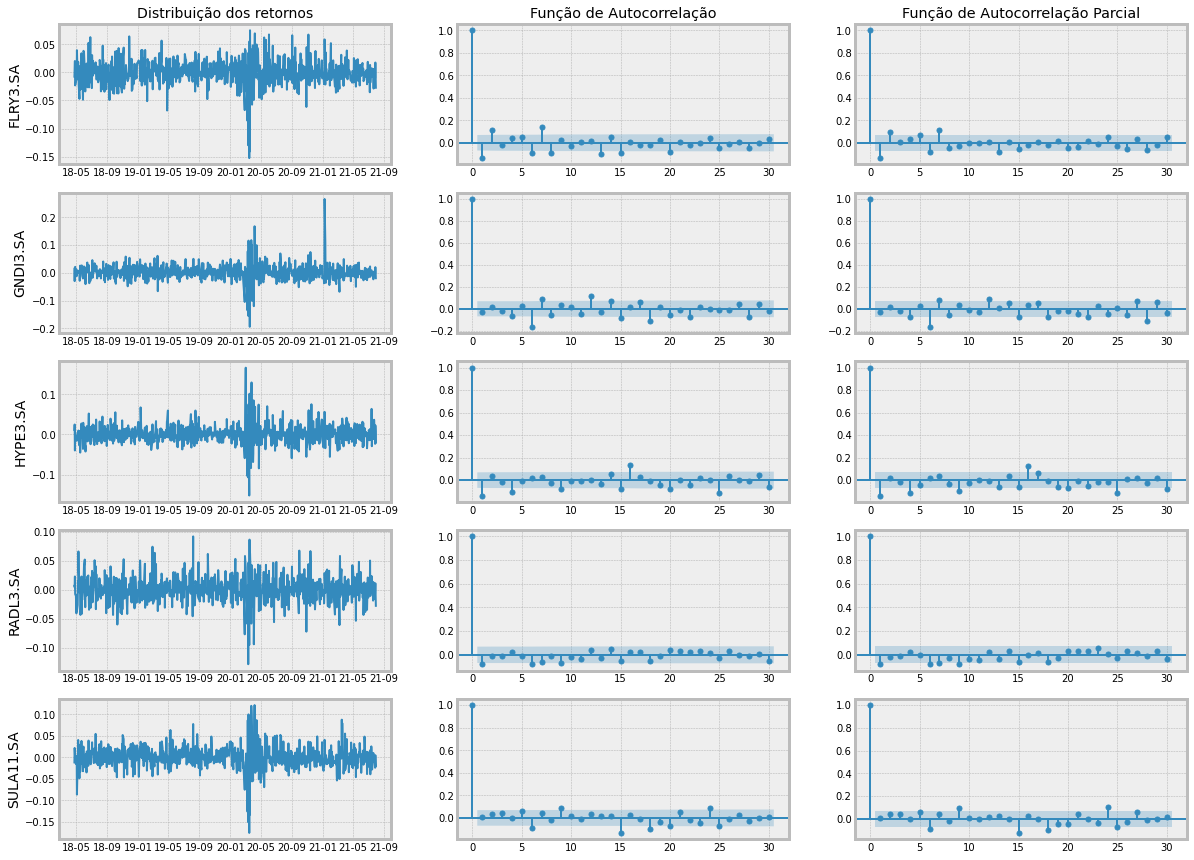

In [618]:
rt_flry = returns_df[['FLRY3.SA']]
rt_gndi = returns_df[['GNDI3.SA']]
rt_hype = returns_df[['HYPE3.SA']]
rt_radl = returns_df[['RADL3.SA']]
rt_sula = returns_df[['SULA11.SA']]

fig, ax = plt.subplots(5,3, figsize = (18,15))

ax[0][0].plot(rt_flry)
ax[0][0].set_title('Distribuição dos retornos', fontsize = 14)
ax[0][0].set_ylabel('FLRY3.SA', fontsize = 14)
ax[0][0].xaxis.set_major_formatter(date_form)
plot_acf(rt_flry, ax = ax[0][1], title = 'Função de Autocorrelação')
plot_pacf(rt_flry, ax = ax[0][2], title = 'Função de Autocorrelação Parcial')

ax[1][0].plot(rt_gndi)
ax[1][0].set_ylabel('GNDI3.SA', fontsize = 14)
ax[1][0].xaxis.set_major_formatter(date_form)
plot_acf(rt_gndi, ax = ax[1][1], title = '')
plot_pacf(rt_gndi, ax = ax[1][2], title = '')

ax[2][0].plot(rt_hype)
ax[2][0].set_ylabel('HYPE3.SA', fontsize = 14)
ax[2][0].xaxis.set_major_formatter(date_form)
plot_acf(rt_hype, ax = ax[2][1], title = '')
plot_pacf(rt_hype, ax = ax[2][2], title = '')

ax[3][0].plot(rt_radl)
ax[3][0].set_ylabel('RADL3.SA', fontsize = 14)
ax[3][0].xaxis.set_major_formatter(date_form)
plot_acf(rt_radl, ax = ax[3][1], title = '')
plot_pacf(rt_radl, ax = ax[3][2], title = '')

ax[4][0].plot(rt_sula)
ax[4][0].set_ylabel('SULA11.SA', fontsize = 14)
ax[4][0].xaxis.set_major_formatter(date_form)
plot_acf(rt_sula, ax = ax[4][1], title = '')
plot_pacf(rt_sula, ax = ax[4][2], title = '')
plt.show()

Ao analisar os gráficos da acf e pacf vemos que é possivel ajustar a série de retornos através de um modelo ARMA antes de ajustar um modelo de volatilidade.

In [646]:
def econometrica(df, posicao_financeira):
    modelos = [arch_model(df[col]*100, mean = 'AR', vol='GARCH', p = 1, q = 1, dist = 'skewt') for col in df.columns]
    modelos_fitados = [modelo.fit(disp='off') for modelo in modelos]
    
    previsao_1 = [fit.forecast(horizon = 1) for fit in modelos_fitados]
    
    mean_1 = [np.sqrt(previsao_1[n].mean[-1:].values[0][0]) for n in range(len(previsao_1))]
    sigma_1 = [np.sqrt(previsao_1[n].variance[-1:].values[0][0]) for n in range(len(previsao_1))]
    
    quantis = [0.01, 0.05, 0.1]
    zs = [modelos[i].distribution.ppf(quantis, modelos_fitados[i].params[-2:]) for i in range(len(modelos))]
    
    var = [[(mean_1[i] + zs[acao][z]*sigma_1[i])*posicao_financeira/100 for (acao,z) in zip(range(len(zs)),range(len(quantis)))]for i in range(len(sigma_1))]
    
    df_out = pd.DataFrame(var, 
                          index = df.columns, 
                          columns = ['VaR (99%)','VaR (95%)','VaR (90%)']).applymap("R$ {0:.2f}".format)
    return df_out, modelos_fitados, modelos

In [647]:
var_econm, fitados_econm, modelos_econm = econometrica(returns_df, 1000)
var_econm

,VaR (99%),VaR (95%),VaR (90%)
FLRY3.SA,R$ -40.35,R$ -24.85,R$ -17.79
GNDI3.SA,R$ -42.06,R$ -25.35,R$ -17.75
HYPE3.SA,R$ -47.85,R$ -29.69,R$ -21.43
RADL3.SA,R$ -45.85,R$ -28.20,R$ -20.17
SULA11.SA,R$ -43.09,R$ -26.30,R$ -18.66


In [490]:
fitados_econm

[                                 AR - GARCH Model Results                                
 Dep. Variable:                          FLRY3.SA   R-squared:                       0.000
 Mean Model:                                   AR   Adj. R-squared:                  0.000
 Vol Model:                                 GARCH   Log-Likelihood:               -1689.72
 Distribution:      Standardized Skew Student's t   AIC:                           3391.45
 Method:                       Maximum Likelihood   BIC:                           3419.59
                                                    No. Observations:                  805
 Date:                           Dom, Ago 01 2021   Df Residuals:                      804
 Time:                                   14:30:17   Df Model:                            1
                                  Mean Model                                
                  coef    std err          t      P>|t|     95.0% Conf. Int.
 --------------------------

In [760]:
def plot_var(df_retornos, modelo, ultima_observ, inicio_prev, titulo):
    plt.rcParams['figure.figsize'] = [16,5]
    modelo_fitado = modelo.fit(disp="off", 
                               last_obs = ultima_observ)
    previsoes = modelo_fitado.forecast(start=inicio_prev,
                                       reindex=False)
    media_condicional = previsoes.mean
    variancia_condicional = previsoes.variance

    zs_distribuicao = modelo.distribution.ppf([0.01, 0.05, 0.1], modelo_fitado.params[-2:])

    value_at_risk = cond_mean.values/100 + np.sqrt(cond_var).values/100 * q[None, :]
    value_at_risk_df = pd.DataFrame(value_at_risk, columns=["1%", "5%", "10%"], index=cond_var.index)
    
    ax = value_at_risk_df.plot(legend=False, xlabel = '', ylabel = 'Retornos')
    xl = ax.set_xlim(value_at_risk_df.index[0], 
                     value_at_risk_df.index[-1])
    yl = ax.set_ylim(-.2, .2)
    
    retornos = df_retornos [inicio_prev:]

    c = []
    for idx in value_at_risk_df.index:
        if retornos.loc[idx][0] < value_at_risk_df.loc[idx, "1%"]:
            c.append("#BB00BB")
        elif retornos.loc[idx][0] < value_at_risk_df.loc[idx, "5%"]:
            c.append("#BB0000")
        elif retornos.loc[idx][0] < value_at_risk_df.loc[idx, "10%"]:
            c.append("#0000CC")
        else:
            c.append("#000000")
    c = np.array(c, dtype="object")
    labels = {
        "#BB00BB": "Excede 1%",
        "#BB0000": "Excede 5%",
        "#0000CC": "Excede 10%",
        "#000000": "Não excede VaR",
    }
    markers = {"#BB0000": "o", "#0000CC": "o","#BB00BB": "o", "#000000": "o"}
    for color in np.unique(c):
        sel = c == color
        ax.scatter(
            retornos.index[sel],
            retornos.loc[sel],
            marker=markers[color],
            c=c[sel],
            label=labels[color],
        )

    ax.set_title(titulo)
    leg = ax.legend(frameon=False, ncol=3)

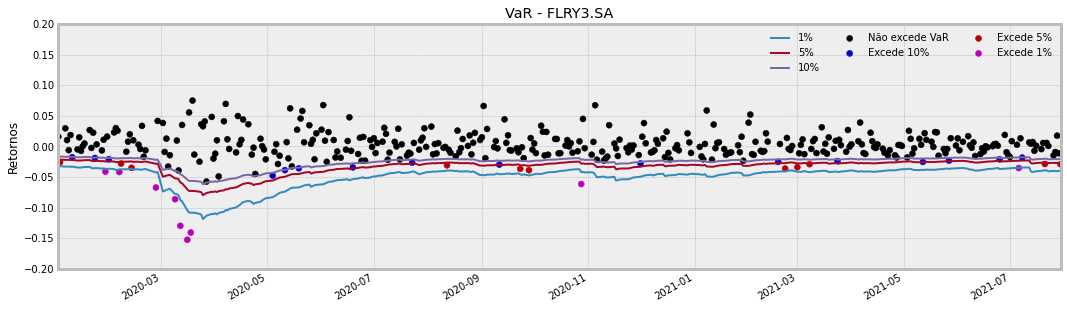

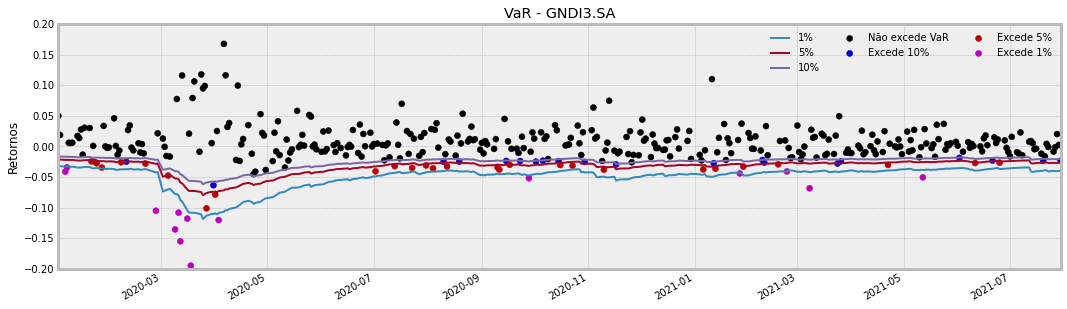

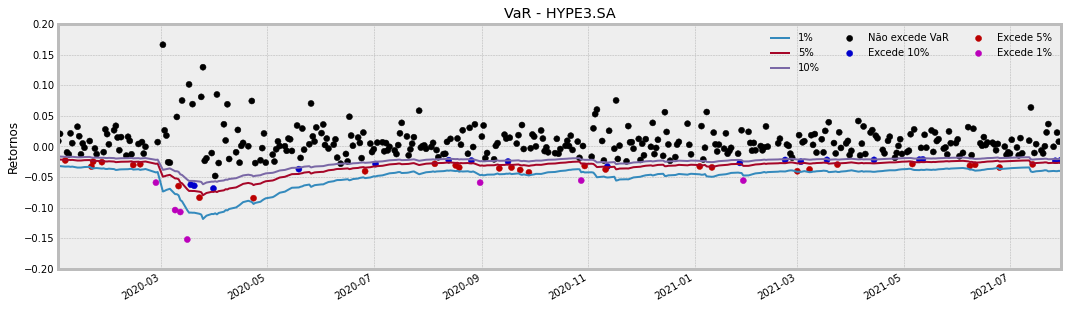

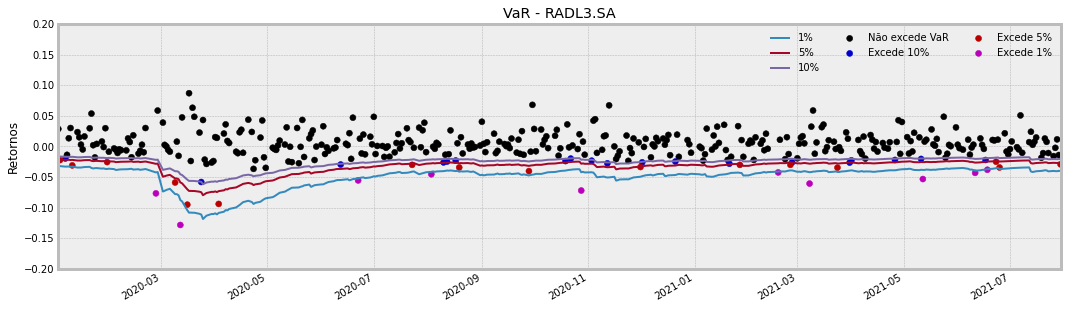

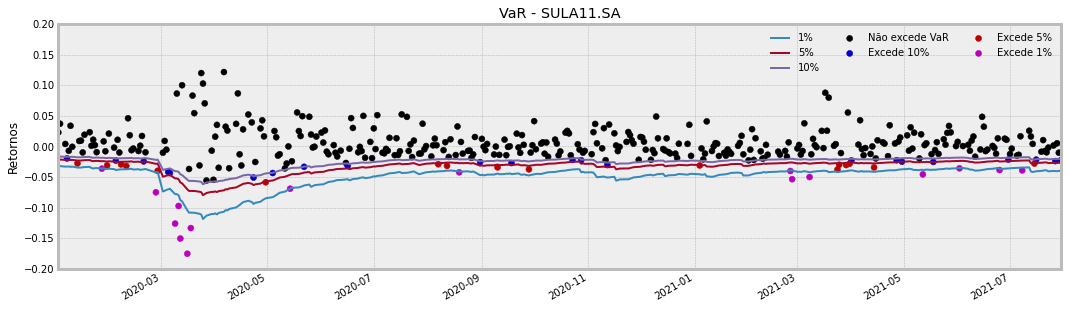

In [762]:
plot_var(rt_flry, modelos[0], "2019-12-31","2020-01-01", 'VaR - FLRY3.SA')
plot_var(rt_gndi, modelos[1], "2019-12-31","2020-01-01", 'VaR - GNDI3.SA')
plot_var(rt_hype, modelos[2], "2019-12-31","2020-01-01", 'VaR - HYPE3.SA')
plot_var(rt_radl, modelos[3], "2019-12-31","2020-01-01", 'VaR - RADL3.SA')
plot_var(rt_sula, modelos[4], "2019-12-31","2020-01-01", 'VaR - SULA11.SA')

# VaR usando quantis empíricos

O uso de quantis empíricos para a determinação do VaR implica numa abordagem não paramétrico do cáculo do VaR, onde não é preciso assumir determinada distribuição das variáveis de retornos, mas acabamos por assumir que a distribuição de perda observada nos retornos históricos será a mesma no período a ser predito.

Sendo os logretornos ordenados pela sua magnitude $r_1, r_2, ...,  r_n $, usamos a i-ésima posição da amostra para calcular o q-quantil da distribuição e assim obtermos o VaR

In [9]:
def var_empirico(df, posicao):
    quantis = [0.01, 0.05, 0.1]
    rt_quantis = [np.quantile(df[[column]], quantis) for column in df.columns]
    var = [x * posicao for x in rt_quantis]
    var = [posicao*rt_quantis[i] for i in range(len(rt_quantis))]
    
    df_out = pd.DataFrame(var, 
                          index = df.columns, 
                          columns = ['VaR (99%)','VaR (95%)','VaR (90%)']).applymap("R$ {0:.2f}".format)
    return df_out

In [10]:
var_empirico(returns_df, 1000)

,VaR (99%),VaR (95%),VaR (90%)
FLRY3.SA,R$ -51.12,R$ -31.77,R$ -23.45
GNDI3.SA,R$ -78.32,R$ -34.42,R$ -25.21
HYPE3.SA,R$ -62.39,R$ -31.52,R$ -23.75
RADL3.SA,R$ -58.04,R$ -30.96,R$ -23.90
SULA11.SA,R$ -58.45,R$ -35.44,R$ -25.53


# VaR usando simulação de montecarlo

Calculate VaR from returns: Using the percentage weights of each asset in the
portfolio and the assets' expected returns, we can calculate the expected portfolio
return X days ahead. Then, we can express VaR as the dollar amount based on
that return and the current portfolio value.
The Monte Carlo approach to determining the price of an asset employs random variables
drawn from the Standard Normal distribution.
we calculated metrics such as the historical averages of the asset return, the
accompanying standard deviations, the last known stock prices, and the initial portfolio
value. In Step 9, we applied the analytical solution to the Geometric Brownian Motion SDE
and calculated possible 1-day-ahead stock prices for both assets.

Para simular as variações da ação da PETR4, deve-se ter primeiro a média dos retornos ( x̄ ) e o desvio-padrão (σ) estimados por um período das cotações em bolsa do ativo.

Através desses dois valores, pode-se gerar um número aleatório entre 0 e 1 e utilizá-lo como probabilidade esperada da máxima perda, ou seja, da variação estar à esquerda do valor crítico representado pelo número de desvios esperados. Em outras palavras, é o valor de um menos o nível de confiança estabelecido.

. Ordenando-se essas variações da maior perda até o maior ganho, estipulando-se um nível de confiança, tem-se o VaR.

In [11]:
def var_monte_carlo(df, posicao_financeira, nSimulacoes):
    quantis = [0.01, 0.05, 0.1]
    media = np.mean(df)
    desvpad = np.std(df)
    valores_simulados_supondo_normal = [random.normal(media[i],
                                        desvpad[i],
                                        nSimulacoes) for i in range(len(media))]
    valores_simulados_ordenados = [np.sort(i) for i in valores_simulados_supondo_normal]
    
    posicao_quantis_simulados = [int(nSimulacoes*i) for i in quantis]
    
    var = [[valores_simulados_ordenados[n][posicao_quantis_simulados[i]]*posicao_financeira\
            for i in range(len(posicao_quantis_simulados))] \
            for n in range(len(valores_simulados_ordenados))]
    
    df_out = pd.DataFrame(var, 
                          index = df.columns, 
                          columns = ['VaR (99%)','VaR (95%)','VaR (90%)']).applymap("R$ {0:.2f}".format)
    return df_out

In [12]:
var_monte_carlo(returns_df, 1000, 5000)

,VaR (99%),VaR (95%),VaR (90%)
FLRY3.SA,R$ -50.73,R$ -35.51,R$ -28.31
GNDI3.SA,R$ -66.46,R$ -46.49,R$ -36.43
HYPE3.SA,R$ -55.60,R$ -38.68,R$ -30.15
RADL3.SA,R$ -50.77,R$ -35.44,R$ -27.89
SULA11.SA,R$ -59.93,R$ -42.27,R$ -33.38
